In [17]:
# import numpy as np
# import pandas as pd
# import seaborn as sns #; sns.set(color_codes=True)
# import os
# import itertools
# import matplotlib.pyplot as plt
from tqdm import tqdm
import pytz
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib.iotools import read_tmy3
import yaml
from datetime import date
import datetime
from numpy import save,load
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
import scipy

# Functions

## Importfunction

In [2]:
def importdata(configfile):
    """Reads and preprocesses csv-files """
    
    # load config file
    
    with open(configfile) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    
    model_path = config['model_path']
    # read in dataframes

    ## read in files
    df_orig = pd.read_csv(config['model_path'] + config['stringdata'], sep = config['stringdata_separator']) 
    df_orig_env = pd.read_csv(config['model_path'] + config['envdata'], sep = config['envdata_separator']) 
    
    df_raw=df_orig
    df_raw_env=df_orig_env

    ## convert to pandas datetime
    df_raw['datetime']=pd.to_datetime(df_raw['datetime'])
    df_raw_env['datetime']=pd.to_datetime(df_raw_env['datetime'])

    ## set datetime as index
    df_raw = df_raw.set_index(['datetime'])#.tz_localize(tz='UTC')
    df_raw_env = df_raw_env.set_index(['datetime'])#.tz_localize(tz='UTC')

    ## drop inverters
    cols_inverters = df_raw.columns[config['inverter_cols']:]
    df_raw=df_raw.drop(columns=cols_inverters)


    ## rename df_env
    df_raw_env['irradiance']=df_raw_env.iloc[:,config['irradiance_col']-1]
    df_raw_env['temperature']=df_raw_env.iloc[:,config['temperature_col']-1]
    df_raw_env=df_raw_env[['temperature','irradiance']]
    
    ## shift to local timezone
    df_raw.index=df_raw.index.shift(config['timezone_shift'],freq='h')
    df_raw_env.index=df_raw_env.index.shift(config['timezone_shift'],freq='h')
    

    return df_raw, df_raw_env, df_orig, df_orig_env, model_path

## Main functions

In [3]:
def measures(input_df,input_df_env,freq, configfile):
    """function that calculates several measures based on the input files"""
    
    # load config file
    with open(configfile) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
        
        
    # fill gaps in index by resampling with original resolution
    df=input_df.resample(config['resolution']).max()
    df_env=input_df_env.resample(config['resolution']).max()

    ## trim start and end date
    df = df[(df.index>=config['start_date']) & (df.index<=config['end_date'])]
    df_env = df_env[(df_env.index>=config['start_date']) & (df_env.index<=config['end_date'])]

    # calculate Power theoretical (call function)
    df_Pt=pt(df_env['irradiance'],df_env['temperature'],config['mu'],config['A'],config['To'],config['gamma'])
    
    # calculate ratio (pr/pt)
    df_ratio=df.div(df_Pt, axis=0)
    
    # calculate a temperature adjusted string output (KW) for each day for each string
    df_temperature_scaled = df.div(temp_adjust(df_env['temperature'],config['To'],config['gamma']), axis=0)
    
    return df, df_env, df_ratio, df_Pt, df_temperature_scaled

In [4]:
def timemask(dataframe, start,end):
    """Generate a Timemask (List of used timestamps)"""
    midday_mask = [ind for ind in dataframe.index if (ind.hour>=start)&(ind.hour<=end)]
    return midday_mask

In [5]:
def pt(irradiance, T,mu,A,To,gamma):
    """Calculate Power theoretical Pt"""
    factor= irradiance*mu*A*(1+(T-To)*gamma)
    return factor

In [6]:
def temp_adjust(T,To,gamma):
    """Calculate temperature adjustment"""
    factor= (1+(T-To)*gamma)
    return factor

### Day-string selection different methods

In [7]:
def decompose_df(df):
    result = []
    trend = []

    for string in df.columns:
        series = df2[string]
        result.append(seasonal_decompose(series, model='additive', freq=52))
        
    return result

In [8]:
def decompose_irr(dfe):
    """Function decomposing strings"""
    result2 = []
    from statsmodels.tsa.seasonal import seasonal_decompose
    from matplotlib import pyplot
    for string in df_env.columns:
        series2 = dfe['irradiance']
        result2.append(seasonal_decompose(series2, model='additive', freq=52))    
    return result2

In [9]:
def day_sel(df_Pt):
    """Function for day selection"""

    dfe = df_env.fillna(0)
    dfe = dfe.groupby(pd.Grouper(freq='h')).mean()
    
    y2 = decompose_irr(dfe)

    trend_th = pd.DataFrame(y2[0].trend)
    trend_th = trend_th.dropna()

    y = decompose_df(df)

    trend_merge = trend.merge(trend_th, on='datetime', how='inner')
    trend_merge = trend_merge[trend_merge.trend > 15]
    trend_merge = trend_merge.groupby(pd.Grouper(freq='h')).sum()
    trend_merge['sum'] = trend_merge.iloc[:,:-1].sum(axis=1)
    trend_merge['median'] = trend_merge.iloc[:,:-1].median(axis=1)

    #Make actual and irradiance arrays for slope calculation 
    trend_theo_array = trend_merge.trend.array
    trend_median_array = trend_merge['median'].array

    slope, intercept, r_value, p_value, std_err  = scipy.stats.linregress(trend_theo_array,trend_median_array)

    trend_merge['rescaled_th']= trend_merge.trend * slope + intercept

    # trend_merge = trend_merge.drop(['trend','sum','median'],axis=1)

    diff = trend_merge.iloc[:,:-1].apply(lambda x: x - trend_merge.iloc[:,-1])
    selected = (diff['median'] < diff['median'].mean()*1.3) & (diff['median'] > diff['median'].mean()*0.93)
    
    return selected

In [10]:
def str_sel(df_Pt):
    """Function for selection of strings"""

    l=[]
    for i in range(380):
        l.append(i)

    new_df = pd.DataFrame(list(df.columns))
    new_df['date'] = '2020-02-22'

    new_df.rename(columns={ new_df.columns[0]: "string_id" }, inplace = True)

    new_df['string_id'] = l

    m_median = m11.groupby(pd.Grouper(freq='d')).median()

    cols = m_median.iloc[0,:]
    new_df["Median Power Output (kW)"] = cols.values

    power_median = new_df['Median Power Output (kW)'].median()
    power_range_max = power_median * 1.01
    power_range_min = power_median * 0.99

    df_selected_strings = pd.DataFrame()

    # save the selected strings in one dateframe
    df_selected_strings.loc[:, 'selected strings'] = new_df[(new_df['Median Power Output (kW)'] > power_range_min) & (new_df['Median Power Output (kW)'] < power_range_max)]['string_id']
    df_selected_strings.dropna(inplace = True)
    df_selected_strings = df_selected_strings.iloc[:,0].reset_index().drop('index', axis = 1).rename({name: 'string_id'}, axis = 1)

    return df_selected_strings

### Flatness of curves

In [11]:
def filter_strings_threshold(dataframe,start_time, end_time, threshold_std=0.01):
    """Filter good performing strings based on flatness of curve (std). Only strings that are performing
    above the median are selected. Uses a midday timewindwo for the analysis"""
    
    time=timemask(dataframe,start_time,end_time)
    
    #calculate the mean and std for each day and string
    df_resampled=dataframe.loc[time].resample('d')
    df_string_mean=df_resampled.mean()
    df_string_std=df_resampled.std()
    
    #calculate the median of all the strings for each day
    df_day_med=df_string_mean.median(axis=1)
    
    ## 1. select flat strings --> strings with small stdv. Returns a boolean mask
    bool_1=df_string_std.lt(threshold_std)
    
    ## 2. select only good performing strings --> strings with mean above median
    bool_2=df_string_mean.gt(df_day_med,axis=0)
    
    ## combine the two boolean masks
    stringmask=bool_1&bool_2
    
    
    ## return aggregated dataframe and boolean mask
    return stringmask
    
    
    

In [12]:
def filter_days(dataframe, start_time, end_time, threshold=0.006):
    """Filter days with good overall performance based on flatness of curve of the median of 
    all the strings (std). Uses a midday timewindwo for the analysis"""
    
    time=timemask(dataframe,start_time,end_time)
    
    # calculate mean and std for all the strings
    df_mean=dataframe.loc[time].mean(axis=1)
    #df_std=dataframe.std(axis=1)
    
    # calculate mean and std for all the days
    df_resample=df_mean.resample('d')
    df_day_mean=df_resample.mean()
    df_day_std=df_resample.std()

    ## select only flat days --> days with small stdv. Returns a boolean mask
    bool_days=df_day_std.lt(threshold)
    print(f'Dayfilter selected {bool_days.sum()} days')
    
    return bool_days
    

$$Pt=I*\mu*A*(1+(T-To)*\gamma)$$

### Manual Selection

In [13]:
def filter_strings_manually(dataframe, yml):
    """Select good performing strings based on a manual selection. Selection provided through yml-File"""
    
    # open yml-file with the list of manually selected days and strings
    with open(f'../00_data/{yml}') as f:
        data = list(yaml.load_all(f, Loader=yaml.FullLoader))

    
    # select strings from the file
    selected_strings=data[0][3]['selected_strings']
    
    # change resolution to day and return boolean mask
    stringmask=dataframe.resample('d').max()
    stringmask[:]=False
    stringmask[selected_strings]=True
    return stringmask
    


In [14]:
def filter_days_manually(dataframe, yml):
    """Select good performing days based on a manual selection. Selection provided through yml-File"""
    
    # open yml-file with the list of manually selected days and strings
    with open(f'../00_data/{yml}') as f:
        data = list(yaml.load_all(f, Loader=yaml.FullLoader))

    selected_days=pd.to_datetime(data[0][0]['selected_days']).date
    
    
    df_resample=dataframe.resample('d').max()
    df_resample['bool']=df_resample.index.isin(list(selected_days))
    df_resample=df_resample['bool']
    return df_resample


### Linear regression functions

In [15]:
def string_correlation_by_phases (string_selected, time_selected):

    """select data for a temporary DF based on day. ***temp = temporary***
    df_temperature_scaled has adjust string output (KW) to a nominal 25C"""
    
    df_env_temp = df_env.loc[time_selected, :]
    df_temp = df_temperature_scaled.loc[time_selected, :]

    # select data for a temporary DF based on day. ***temp = temporary***

    df_temp = df_temp.join(df_env_temp['irradiance'])

    ##  Calculate linear regression coefficients - sklearn
    x = df_temp['irradiance'].values.reshape(-1,1)
    y = df_temp[string_selected].values

    reg = LinearRegression(fit_intercept = False).fit(x, y)
    # r2_error = reg.score(x, y) # r2 is easily accessed error message
    beta0 = reg.coef_[0] 
    beta1 = reg.intercept_ # set to zero

    # Make predictions using the testing set
    y_pred = reg.predict(x)
    mse = mean_squared_error(y, y_pred)
    nrmse = np.sqrt(mse)/(df_temp[string_selected].max() - df_temp[string_selected].min())

    return nrmse, beta0, beta1 

In [16]:
def string_correlation(cols_strings, days_window, threshold_up, threshold_steady, threshold_down):
    """calculate a 3D array with linear correlation of string power (temp adjusted) vs irradiance
    3 parameters (error, intercept, slope) * 4 slopes (up, steady, down, all)"""
    # create array with NaNs
    strings_corr = np.empty((len(days_window), len(cols_strings), 12))
    strings_corr[:] =np.nan # fill with nan's 

    for day in tqdm(range(len(days_window))):  
        print('starting day: '+ str(day))
        df_env_temp = df_env[df_env.index.date == days_window[day].date()] 

        # windows for up-slope and down slope
        up_ind = df_env_temp[df_env_temp['irradiance'].diff()>threshold_up].index
        down_ind = df_env_temp[df_env_temp['irradiance'].diff()<threshold_down].index

        # windows for steady state - must sit between the upslope and downslope
        steady_ind =df_env_temp[(df_env_temp['irradiance'].diff()>-threshold_steady) 
                             & (df_env_temp['irradiance'].diff()<threshold_steady)
                             & (df_env_temp['irradiance'].index>up_ind.max())
                             & (df_env_temp['irradiance'].index<down_ind.min())].index
        # window for full day
        all_ind =df_env_temp[df_env_temp['irradiance']>0].index

    ## loop through up_slope
        for strings in range(len(cols_strings)): #len(cols_strings)
            try:        
                nrmse, beta0, beta1 = string_correlation_by_phases(cols_strings[strings], up_ind) 
            except ValueError as e: 
                print('error on up_slope ' + str(e))
                print('day: '+ str(day))
                print('string: '+ cols_strings[strings])
                # don't break out
            else: 
                strings_corr[day, strings, 0] = nrmse
                strings_corr[day, strings, 1] = beta0
                strings_corr[day, strings, 2] = beta1

    ## loop through steady state - error checking needed!
        for strings in range(len(cols_strings)): #len(cols_strings)
            try:        
                nrmse, beta0, beta1 = string_correlation_by_phases(cols_strings[strings], steady_ind) 
            except ValueError as e: 
                print('error on steady slope ' + str(e))
                print('day: '+ str(day))
                print('string: '+ cols_strings[strings])
                break # exit for-loop - typical that all strings will fail
            else:    
                strings_corr[day, strings, 3] = nrmse
                strings_corr[day, strings, 4] = beta0
                strings_corr[day, strings, 5] = beta1

    ## loop through down_slope
        for strings in range(len(cols_strings)): #len(cols_strings)
            try:        
                nrmse, beta0, beta1 = string_correlation_by_phases(cols_strings[strings], down_ind) 
            except ValueError as e: 
                print('error on down slope ' + str(e))
                print('day: '+ str(day))
                print('string: '+ cols_strings[strings])
                # don't break out
            else:    
                strings_corr[day, strings, 6] = nrmse
                strings_corr[day, strings, 7] = beta0
                strings_corr[day, strings, 8] = beta1
    ## loop through full window
        for strings in range(len(cols_strings)): #len(cols_strings)
            try:        
                nrmse, beta0, beta1 = string_correlation_by_phases(cols_strings[strings], all_ind) 
            except ValueError as e:  
                print('error on full slope ' + str(e))
                print('day: '+ str(day))
                print('string: '+ cols_strings[strings])
                # don't break out
            else:    
                strings_corr[day, strings, 9] = nrmse
                strings_corr[day, strings, 10] = beta0
                strings_corr[day, strings, 11] = beta1
    
    return strings_corr  

In [17]:

def filter_strings_lin_reg(strings_corr, selected_slope_type, error_threshold, slope_threshold, cols_strings, df_sum_day):
    """convert np.array to DF to track days and strings"""
    df_section_err = pd.DataFrame(strings_corr[:,:,0+ selected_slope_type*3], columns = cols_strings)
    df_section_err.index = df_sum_day.index
    df_section_slope = pd.DataFrame(strings_corr[:,:,1+ selected_slope_type*3], columns = cols_strings)
    df_section_slope.index = df_sum_day.index

    # this gives the gradient of the slope when above thresholds and then NaNs
    df_section_slope_threshold = df_section_slope[(df_section_err<=error_threshold) & (df_section_slope>=slope_threshold)]

    # this gives a boolean mask of selcted days and strings
    stringmask = df_section_slope_threshold.gt(0)

    return df_section_slope, stringmask 

In [18]:
def mask_linear_correlation(selected_slope_type, error_threshold, slope_threshold = 0.003):
    """Analysis of linear correlation"""
    slope_type = {0: 'upslope', 
                  1: 'steady-state', 
                  2: 'downslope', 
                  3: 'all'}

    # column labels for all strings
    cols_strings = df.columns #

    # unique list of days
    df_sum_day = df_env.groupby(pd.Grouper(freq='d')).sum()/12 # divide by 12 to convert 5' into KWh
    days_window = df_sum_day.index 

    # load saved correlation array if necessary
    strings_corr  = load(model_path+'strings_corr_2020-07-30.npy')
    # print(strings_corr.shape)


    df_section_slope, stringmask = filter_strings_lin_reg(strings_corr, selected_slope_type, error_threshold, slope_threshold, cols_strings, df_sum_day) 

    return df_section_slope, stringmask

### Apply boolean mask

In [19]:
def mask_result(dataframe, mask):
    """applies the boolean selection mask on the df or df_ratio dataframe."""
    
    #mask a dataframe with the boolean mask. dataframe and boolean mask must have the same number of columns
    df_merge=dataframe.index.to_frame()
    mask['datemask']=mask.index
    df_result = df_merge.merge(mask, left_on=pd.to_datetime(df_merge.index.date), right_on='datemask')
    df_result = df_result.set_index(['datetime'])
    mask.drop(columns='datemask', inplace=True)
    return dataframe[df_result]

## Functions for plotting

In [20]:
def violin_plot(dataframe, y_name='pa/pt', x_name='month'):
    
    
    
    data=stack(dataframe,y_name)
    sns.set(style="whitegrid", palette="pastel", color_codes=True, )

    # Draw a nested violinplot and split the violins for easier comparison
    sns.violinplot(y=y_name, x=x_name,
                   split=False, inner="quart",


                   data=data)
    sns.despine(left=True)
    return data

In [40]:
def dayplots(dataframe, start_time, end_time, resample, y_lower, y_upper, 
             filename,dataframe_Pt=None,mask=None,start_time_analysis='10:00',end_time_analysis='15:00'):
    """creates one plot for each day and saves it as a png-file"""
    
    if mask is not None:
        
        dataframe=mask_result(dataframe,mask)

        
    
    timewindow=timemask(dataframe,start_time,end_time)
    data=dataframe.loc[timewindow].resample(resample).mean().quantile((0.25,0.5,0.75),axis=1).transpose()
    if dataframe_Pt is not None:
        data=data.join(dataframe_Pt.loc[timewindow].resample(resample).mean().to_frame())
        data.rename(columns={0:'Pt'},inplace=True)

    data.rename(columns={0.25:'Q1',0.5:'median',0.75:'Q2'},inplace=True)

    # add time colums
    data['month'] = data.index.strftime('%y-%m')
    data['hour']=data.index.hour
    data['day']=data.index.weekday
    data['week']=data.index.week
    data['date']=data.index.date
    data['timedec']=(data.index.hour*60+data.index.minute)/60
    data['start_time']=start_time_analysis
    data['end_time']=end_time_analysis
    data.dropna(inplace=True)
    

    #cheap hack to define a one-color palette for the individual strings
    colors_hue=list(np.full((400), '#666666'))
    #num_colors=data['string'].nunique()
    
    #generate diagram
    sns.set()
    sns.set_style("whitegrid",{'grid.color': '.95',})
    sns.set_palette('dark')
    sns.set_context("poster")
    sns.set_palette(sns.color_palette(colors_hue, 400))
    g = sns.FacetGrid(data, row="week", col="day",height=6)
    g = g.map(sns.lineplot, 'timedec', 'median', ci=None, color='#4f7fa9',linewidth=4, alpha=0.8)
    if dataframe_Pt is not None:
        g = g.map(sns.lineplot, 'timedec', 'Pt', ci=None, color='red',linewidth=1, alpha=0.8)
    g = g.map(plt.fill_between, 'timedec','Q1','Q2',alpha=0.3,color='#4f7fa9',zorder=4)
    
    for idx, ax in enumerate(g.fig.axes):
        ax.axvline(9, ls='--',alpha=0.4)
        ax.axvline(16, ls='--',alpha=0.4)
    
    
    

    

              
    

    g.set(ylim=(y_lower, y_upper),xlim=(start_time, end_time+1))
    labels=data['timedec'].unique()
    
    #g.set_xticklabels(labels=labels)
    g.savefig(f'../30_output/{filename}')
    
    
    return data

In [22]:
def yearplot(dataframe, x_lower, x_upper, start_time, end_time, x_name='date', y_name='pa/pt', mask=None):
    """creates a line plot with data aggregated by day. Uses a midday-window."""
    
    df_Pavlin=dataframe
    
    if isinstance(dataframe,pd.Series):
        df_Pavlin=df_Pavlin.to_frame() #cheap trick to turn into frame
        df_Pavlin.rename(columns={0: 'value'}, inplace=True)
        
    time=timemask(df_Pavlin, start_time,end_time) # timewindow that will be plotted
    df_pavlin=df_Pavlin.loc[time].resample('d').median() #
    
    if mask is not None:
        df_pavlin=df_pavlin[mask.sum(axis=1)!=0]
        

    # stack data
    data=stack(df_pavlin,y_name)
    
    # merge P theoretical and match scale with p actual   
    data = data.merge(df_Pt.to_frame(), left_on=pd.to_datetime(data.index), right_on=df_Pt.to_frame().index)
    data['pt']=data[0]
    
    #cheap hack to define a one-color palette for the individual strings
    colors_hue=list(np.full((400), '#666666'))
    num_colors=data['string'].nunique()
    
    #generate diagram
    plt.figure(figsize=(16, 6))
    sns.set()
    sns.set_style("whitegrid",{'grid.color': '.95',})
    sns.set_palette('dark')
    sns.set_context("poster")
    sns.set_palette(sns.color_palette(colors_hue, num_colors))
    
    #g = sns.lineplot(data=data, x=x_name, y=y_name,hue="string",ci=None, alpha=0.1, legend=None, size=0.1 )
    g = sns.lineplot(data=data, x=x_name, y=y_name, markers='x',color='red',linewidth=2, alpha=0.8,ci=None,estimator=np.median)

    bounds = data.groupby(x_name)[y_name].quantile((0.25,0.75)).unstack()
    g.fill_between(x=bounds.index,y1=bounds.iloc[:,0],y2=bounds.iloc[:,1],alpha=0.1,color='red',zorder=3)
    

    g.set(ylim=(x_lower, x_upper))
    
    # define Labels and Axis
    g.set(ylim=(x_lower, x_upper),xlabel='', ylabel=y_name)
    labels=data['key_0'].dt.strftime('%b').unique()
    g.set_xticklabels(labels=labels)
    

    
    
    return data
    
    
    
    

In [23]:
def yearplot_combined(dataframe_Pa, dataframe_Pt, x_lower, x_upper, x_perc_lower, x_perc_upper, start_time, end_time, 
                      x_name='date', y_name='kw', mask=None):
    
    """creates a fancy 3-line plot with data aggregated by day. Uses a midday-window."""
    
    # prepare data
    
    time=timemask(dataframe_Pa, start_time, end_time) # define datimewindow that will be plotted
    df_Pa=dataframe_Pa.loc[time].resample('d').median() # aggregate Pa by day and select timewindow
    df_Pt=dataframe_Pt.loc[time].resample('d').median() # aggregate Pt by day and select timewindow
    
    # mask Pt 
    # TODO Pt_mask in Pipeline!!!!
    
    if mask is not None:
        df_Pt=df_Pt[mask.sum(axis=1)!=0]



    # stack Pa
    data=stack(df_Pa,y_name)
   
    # merge Pt   
    data = data.merge(df_Pt.to_frame(), left_on=pd.to_datetime(data.index), right_on=df_Pt.to_frame().index)
    data['pt']=data[0]
    
    # create Dataframe for IQR and merge it, calculate bounds for Pa/Pt-Ratio
    bounds = data.groupby(x_name)[y_name].quantile((0.25,0.5,0.75)).unstack()
    data = data.merge(bounds, left_on='date', right_on=bounds.index)
    data.rename(columns={0.25: 'Q1',0.75:'Q3'}, inplace=True)
    data['diff_lower']=data['Q3']/data['pt']*10
    data['diff_upper']=data['Q1']/data['pt']*10
    
    #cheap hack to define a one-color palette for the individual strings
    # TODO check if still needed
    colors_hue=list(np.full((400), '#666666'))
    num_colors=data['string'].nunique()
    
    #define diagram
    plt.figure(figsize=(16, 6))
    sns.set()
    sns.set_style("whitegrid",{'grid.color': '.95',})
    sns.set_palette('dark')
    sns.set_context("poster")
    sns.set_palette(sns.color_palette(colors_hue, num_colors))
    
    # plot Pa and Pt
    g = sns.lineplot(data=data, x=x_name, y=y_name, color='red',linewidth=2, alpha=0.8,estimator = np.median, ci=None)
    g = sns.lineplot(data=data, x=x_name, y=y_name, color='red',linewidth=2, alpha=0.8,estimator = np.median, ci=None)
    g = sns.lineplot(data=data, x=x_name, y='pt', color='black',linewidth=2, alpha=0.8,estimator = np.median, ci=None)
    
    # plot IQR for Pa
    g.fill_between(x=bounds.index,y1=bounds.iloc[:,0],y2=bounds.iloc[:,2],alpha=0.1,color='red',zorder=4)

    # create 2nd axis
    g2 = g.twinx()
    g2.set_ylabel('Second Axis!')
    
    # plot range for Pa/Pt Ratio
    g.fill_between(x=data['date'],y1=data['diff_lower'],y2=data['diff_upper'],alpha=0.1, color='black',zorder=3)
    
    # define Labels and Axis
    g.set(ylim=(x_lower, x_upper),xlabel='', ylabel='Output (kw)')
    g2.set(ylim=(x_perc_lower, x_perc_upper),xlabel='', ylabel='Efficiency % (Pa/Pt)')
    labels=data['key_0'].dt.strftime('%b').unique()
    g.set_xticklabels(labels=labels)
    g2.grid(False)
    
    
    return bounds,data
    
    
    
    

In [24]:
# will unstack and add data colums
def stack(dataframe, measure_name):
    """helper function that stacks df or df_ratio and atts several time-columns"""
    
    #drop rows and colums with only nan's
    df_cleaned=dataframe.copy(deep=True)
    df_cleaned.dropna(how='all',axis=1, inplace=True)
    df_cleaned.dropna(how='all',axis=0, inplace=True)
    
    
    # stack dataframe
    df_stacked=df_cleaned.stack().reset_index()
    df_stacked.rename(columns={0: measure_name,'level_1':'string'}, inplace=True)
    df_stacked = df_stacked.set_index(['datetime'])
    
    # add time colums
    df_stacked['month'] = df_stacked.index.strftime('%y-%m')
    df_stacked['hour']=df_stacked.index.hour
    df_stacked['day']=df_stacked.index.weekday
    df_stacked['week']=df_stacked.index.week
    df_stacked['date']=df_stacked.index.date
    df_stacked['time']=df_stacked.index.strftime('%H:%M')
    
    return df_stacked
    
    
    
    

## Function to generate Clearsky Model

In [25]:
def clearsky(timeseries,configfile):
    """creates a clearsky-model based on provided location (in the config-file)"""
    
    with open(configfile) as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    
    
    
    
    
    tus = Location(config['lat'], config['long'], config['timezone'], 2122, 'Test')
    
    times = timeseries
    
    cs = tus.get_clearsky(times)  # ineichen with climatology table by default
    cs.index=cs.index.shift(config['timezone_shift'],freq='h')
    
    return cs
    

# Preprocess for Linear regression

In [26]:
# # import data
# df_raw, df_raw_env, df_orig, df_orig_env, model_path=importdata(configfile)

# #generate measures
# # NBED use config file rather than 5'
# df, df_env, df_ratio, df_Pt, df_temperature_scaled=measures(df_raw,df_raw_env,configfile)



# ## Runs linear regression - takes LONG time to run
# # calculate a 3D array with linear correlation of string power (temp adjusted) vs irradiance
# # 3 parameters (error, intercept, slope) * 4 slopes (up, steady, down, all)

# # set parameters, leave gaps between the transitions
# threshold_up = 20 # minimum gradient for ramp-up
# threshold_steady = 10 # min/ max gradient for steady state
# threshold_down = - threshold_up # set as negative of ramp_up

# # column labels for all strings
# cols_strings = df.columns #

# # unique list of days
# df_sum_day = df_env.groupby(pd.Grouper(freq='d')).sum()/12 # divide by 12 to convert 5' into KWh
# days_window = df_sum_day.index # ignore zero days [df_sum_day['irradiance']>0]

# strings_corr = string_correlation(cols_strings, days_window, threshold_up, threshold_steady, threshold_down)

# # save array to npy file
# today = str(date.today())
# save(model_path +'strings_corr_'+ today +'.npy', strings_corr)

# Pipeline

## Import Data

In [27]:
# choose config file
configfile='../00_data/config.yml'

In [28]:
# import data
df_raw, df_raw_env, df_orig, df_orig_env, model_path=importdata(configfile)

## Calculate measures, filter good days and good strings, output violin plot

Dayfilter selected 110 days


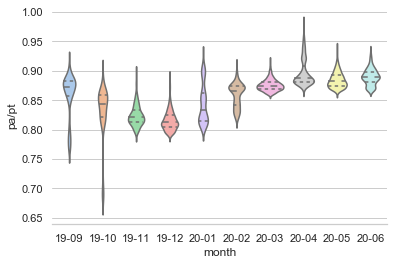

In [56]:
#GENERATE MEASURES

df, df_env, df_ratio, df_Pt, df_temperature_scaled=measures(df_raw,df_raw_env,'5min', configfile)
df_clearsky=clearsky(df_ratio.index, configfile)


#GENERATE BOOLEAN MASKS FOR FILTERING (select method you want)

# #-------------------------
# # Day-string selection different methods. TDOD @Konstantinos: finalize
# df = df.groupby(pd.Grouper(freq='h')).mean()
# df2 = df.fillna(0)
# y = decompose_df(df)
# trend = pd.DataFrame()

# for i in tqdm(range(len(y))):
#     trend[i] = pd.Series(y[i].trend)
    
# #-------------------------






#-------------------------
#flatness of curve
daymask=filter_days(df_ratio,9,15,0.017)
stringmask= filter_strings_threshold(df_ratio,9,15,threshold_std=0.02)
mask=stringmask.mul(daymask, axis=0)
mask_inv=mask.applymap(lambda x: not(x))
mask1d=mask.sum(axis=1)!=0
#-------------------------

# #-------------------------
# #Manual selection
# daymask=filter_days_manually(selected_days,df_ratio)
# stringmask=filter_strings_manually(df_ratio, selected_strings)
# #combine masks
# mask=stringmask.mul(daymask, axis=0)
# mask_inv=mask.applymap(lambda x: not(x))
# #-------------------------


# #-------------------------
# #linear regression
# #Select if looking at: 

# #     slope_type = {0: 'upslope', 
# #                   1: 'steady-state', 
# #                   2: 'downslope', 
# #                   3: 'all'}

# # choose an r2 error value

# # slope_threshold = 0.003 # don't change without thinking - exclude low slope values... 

# df_section_slope, mask = mask_linear_correlation(3,0.99)
# mask_inv=mask.applymap(lambda x: not(x))
# #-------------------------



# #-------------------------
# #no filtering
# mask=df_ratio.resample('d').max()
# mask[:]=True
# mask_inv=mask.applymap(lambda x: not(x))
# #-------------------------



#MASK THE DATA WITH THE BOOLEAN MASK

df_ratio_mask=mask_result(df_ratio, mask)
df_mask=mask_result(df, mask)

df_ratio_invmask=mask_result(df_ratio, mask_inv)
df_invmask=mask_result(df, mask_inv)


#PLOT VIOLIN DIAGRAM
time=timemask(df_ratio_mask, 10,14) # timewindow for aggregating
df_violin=df_ratio_mask.loc[time].resample('d').mean() # aggregate by one day
stacked_violin=violin_plot(df_violin,'pa/pt','month') # plot violin-diagrams for each month



#dummy mask. Only used for ploting
dummymask=df_ratio.resample('d').max()
dummymask[:]=True





# Generate Charts

In [67]:
# #Don't use at the moment. if you run this the other diagrams won't work anymore...
# #Show number of selected strings on selected days
# selected_days_strings=df_ratio_masked.resample('d').max()
# selected_days_strings
# test=mask_result(df_ratio,mask)
# test2=test.resample('d').max()
# test2.count(axis=1).plot(figsize=(30,5))
# #plt.set_aspect(0.20)


# Yearplots

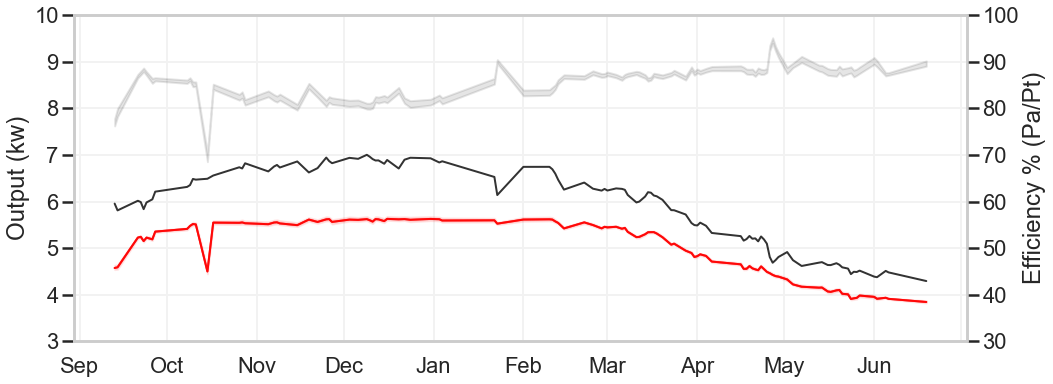

In [32]:

bounds, stacked_pavlinplot=yearplot_combined(df_mask,df_Pt,y_name='kw',start_time=9, end_time=16, 
                                             x_lower=3,x_upper=10, x_perc_lower=30,x_perc_upper=100, mask=mask)

## Clearsky Irradiance

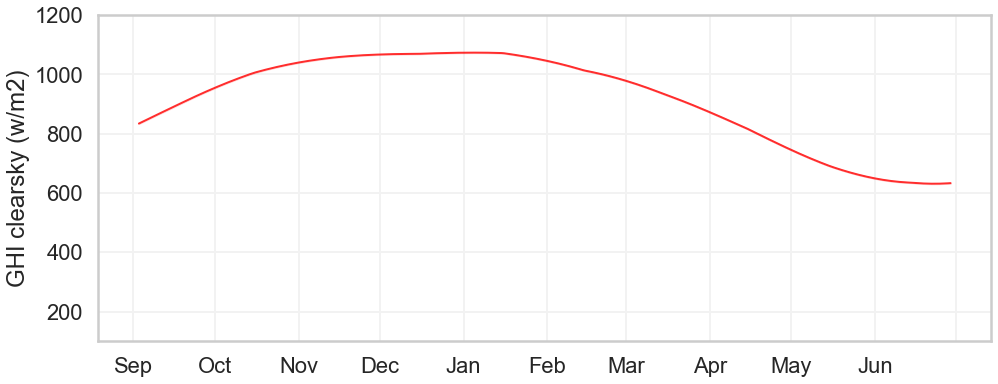

In [57]:
# plot pavlinplot df_clearsky. TODO @daniel: currently not working
clearsky_stacked=yearplot(df_clearsky['ghi'],y_name='GHI clearsky (w/m2)', start_time=9, end_time=16, 
                          x_lower=100,x_upper=1200)

## Irradiance

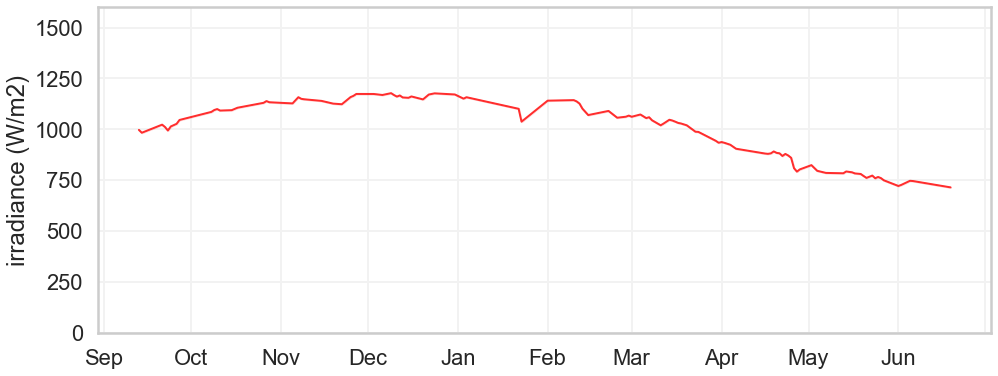

In [58]:
# IRRADIANCE FILTERED

irradiance_stacked=yearplot(df_env['irradiance'],start_time=9, end_time=16,
                            y_name='irradiance (W/m2)',x_lower=0,x_upper=1600, mask=mask)

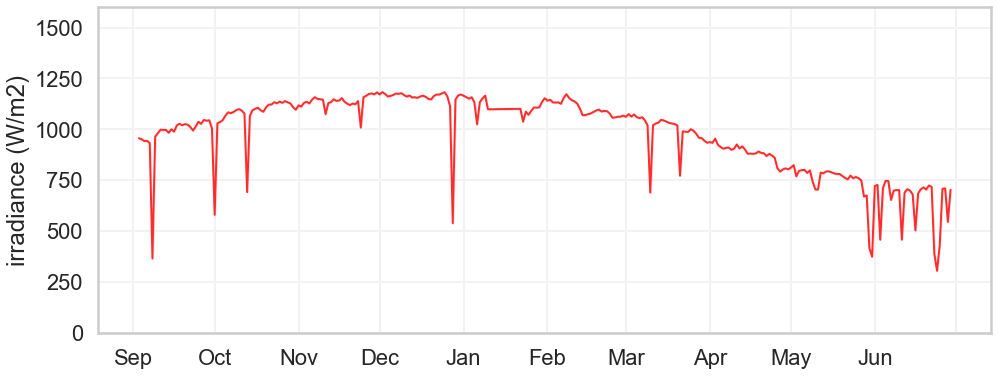

In [59]:
# IRRADIANCE UNFILTERED

irradiance_stacked=yearplot(df_env['irradiance'],start_time=9, end_time=16,
                            y_name='irradiance (W/m2)',x_lower=0,x_upper=1600, mask=None)

## Power theoretical

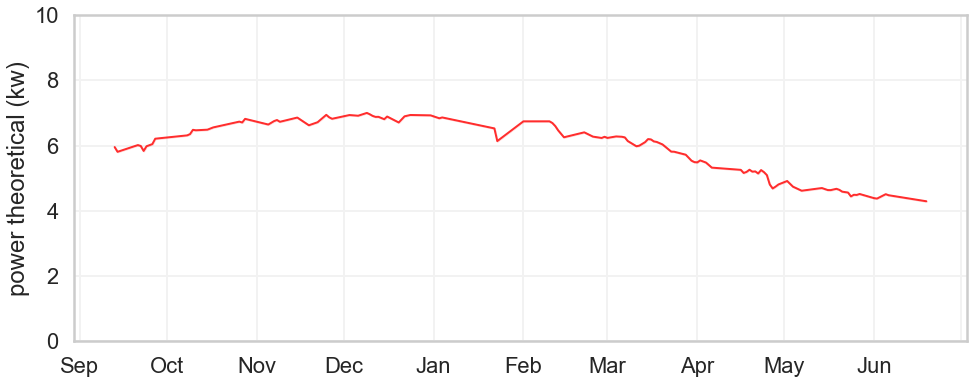

In [35]:
# POWER THEORETICAL FILTERED

Pt_stacked=yearplot(df_Pt,y_name='power theoretical (kw)', start_time=9, end_time=16, 
                    x_lower=0,x_upper=10, mask=mask)

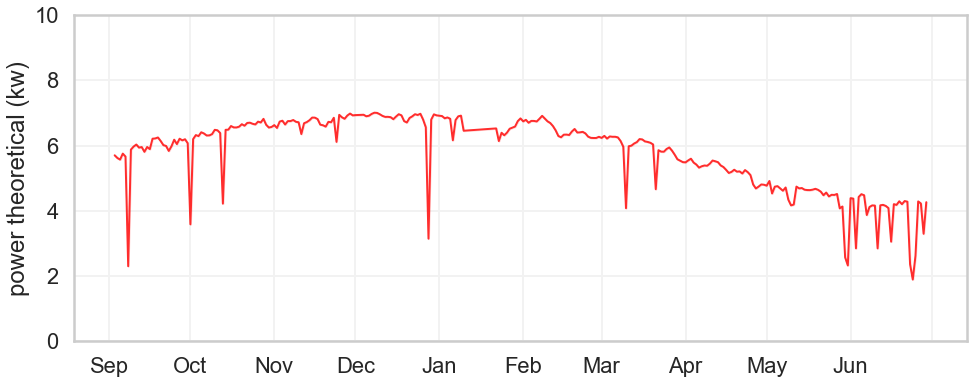

In [60]:
# POWER THEORETICAL UNFILTERED

Pt_stacked_unfiltered=yearplot(df_Pt,y_name='power theoretical (kw)', start_time=9, end_time=16, 
                               x_lower=0,x_upper=10)



## Power actual

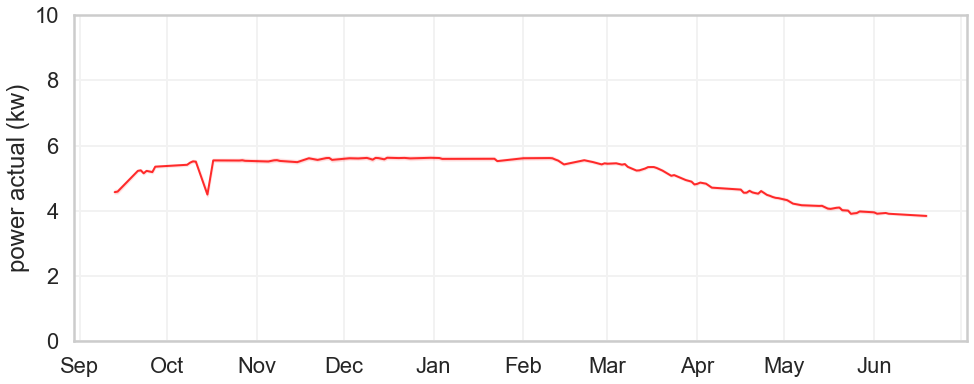

In [61]:
# POWER ACTUAL FILTERED

Pa_stacked=yearplot(df_mask,y_name='power actual (kw)', start_time=9, 
                    end_time=16, x_lower=0,x_upper=10)

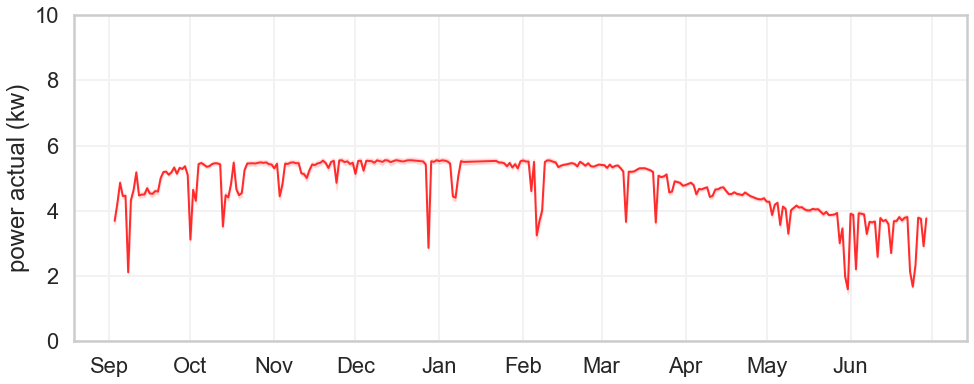

In [62]:
# POWER ACTUAL UNFILTERED

Pa_stacked_unfiltered=yearplot(df,y_name='power actual (kw)', start_time=9, end_time=16, 
                               x_lower=0,x_upper=10)

## Pa/Pt

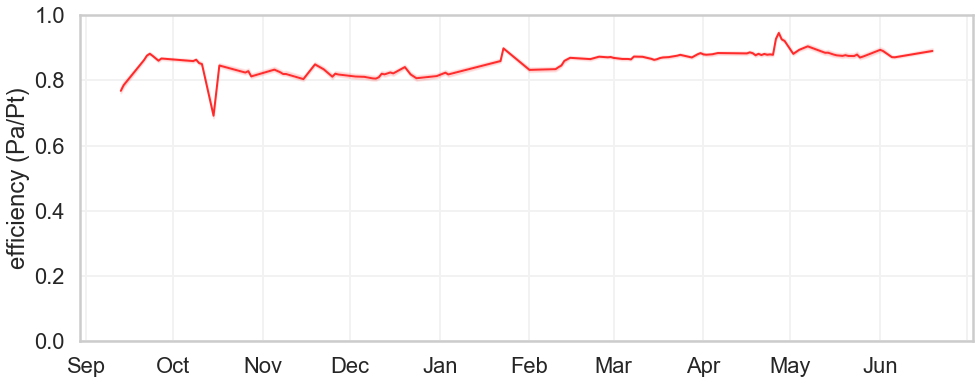

In [39]:
# PA/PT FILTERED
ratio_stacked=yearplot(df_ratio_mask,y_name='efficiency (Pa/Pt)', start_time=9, end_time=16, 
                       x_lower=0,x_upper=1)

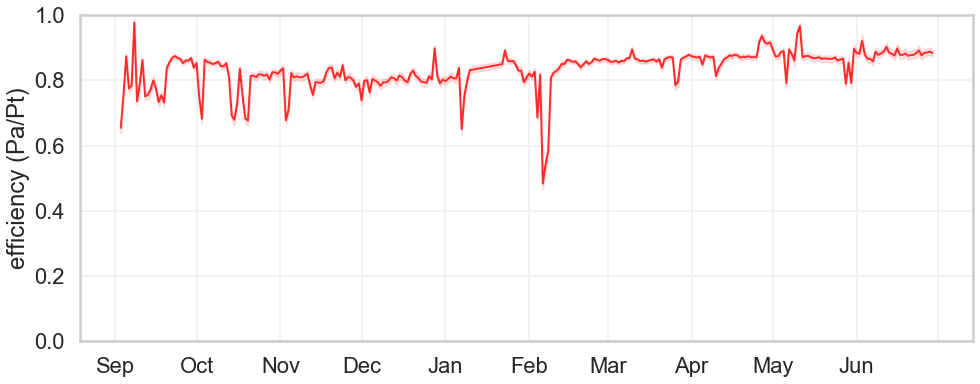

In [63]:
# PA/PT UNFILTERED
ratio_stacked=yearplot(df_ratio,y_name='efficiency (Pa/Pt)', start_time=9, end_time=16, 
                       x_lower=0,x_upper=1)

## Diagrams for each day
Useful to check the selected and unselected days and strings. Take some time to generate

In [42]:
##SELECT THE DIAGRAMS YOU WANT

# #Pt of selected days
# power_selected=dayplots(df,5,19,'30min',0,10,'power_selected.png',dataframe_Pt=df_Pt, mask=mask)
# print('power selected')

# #Pt_ratio of selected days
# ratio_selected=dayplots(df_ratio,9,15,'30min',0,1,'ratio_selected.png',mask=mask)
# print('ratio selected')

# #Pt of all days
# dayplots(df,5,19,'30min',0,10,'power_all.png',dataframe_Pt=df_Pt, mask=None)
# print('power unselected')

# #Pt_ratio of all days
# dayplots(df_ratio,10,12,'15min',0,1,'ratio_all.png',mask=None)
# print('ratio unselected')

# #Pt of all days that are not selected
# unselectmask=dummymask.mul(daymask, axis=0).applymap(lambda x: not(x))
# power_all=dayplots(df,5,19,'30min',0,10,'power_unselected.png',dataframe_Pt=df_Pt, mask=unselectmask)
# print('power all')

# #Pt_ratio all days
# ratio_all=dayplots(df_ratio,9,16,'30min',0,1,'ratio_unselected.png',mask=unselectmask)
# print('ratio all')